# Let's fix this pandemonium

In [6]:
import numpy as np

dataset_cleaned = np.load('../data/new_beggining/clean_mars.npz', allow_pickle=True)
X_train = dataset_cleaned['X_train']
y_train = dataset_cleaned['y_train']

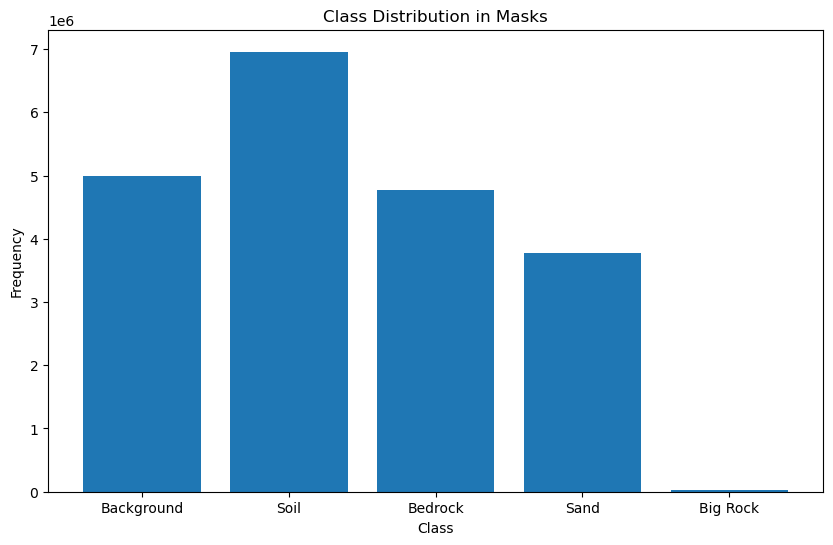

In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(mask_array):
    # Define class names
    class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
    class_counts = np.bincount(mask_array.flatten().astype(int))
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Masks')
    plt.show()

# Plot the distribution
plot_class_distribution(y_train)

In [8]:
from sklearn.manifold import TSNE

# Perform t-SNE on the dataset without the aliens
tsne_no_aliens = TSNE(n_components=2, random_state=42)
y_train_tsne_no_aliens = tsne_no_aliens.fit_transform(y_train.reshape(y_train.shape[0], -1))

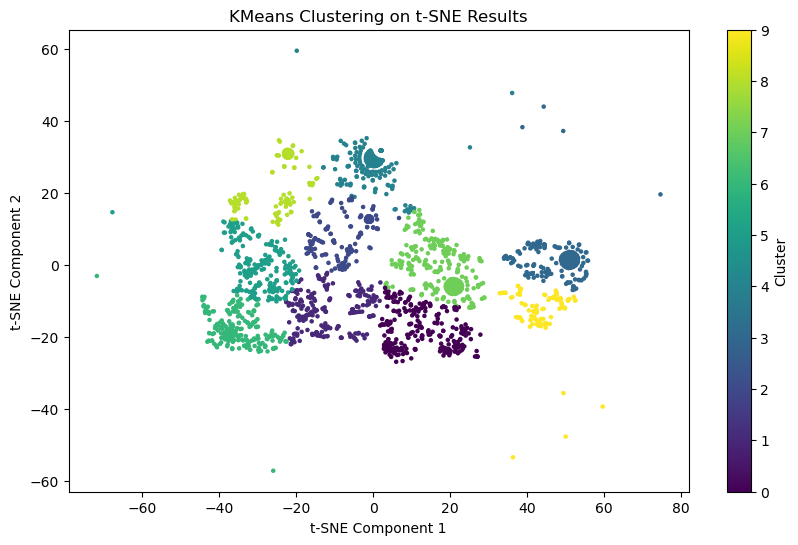

In [9]:
from sklearn.cluster import KMeans

# Perform KMeans clustering on the t-SNE results
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(y_train_tsne_no_aliens)

# Plot the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(y_train_tsne_no_aliens[:, 0], y_train_tsne_no_aliens[:, 1], c=kmeans_labels, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('KMeans Clustering on t-SNE Results')
plt.show()

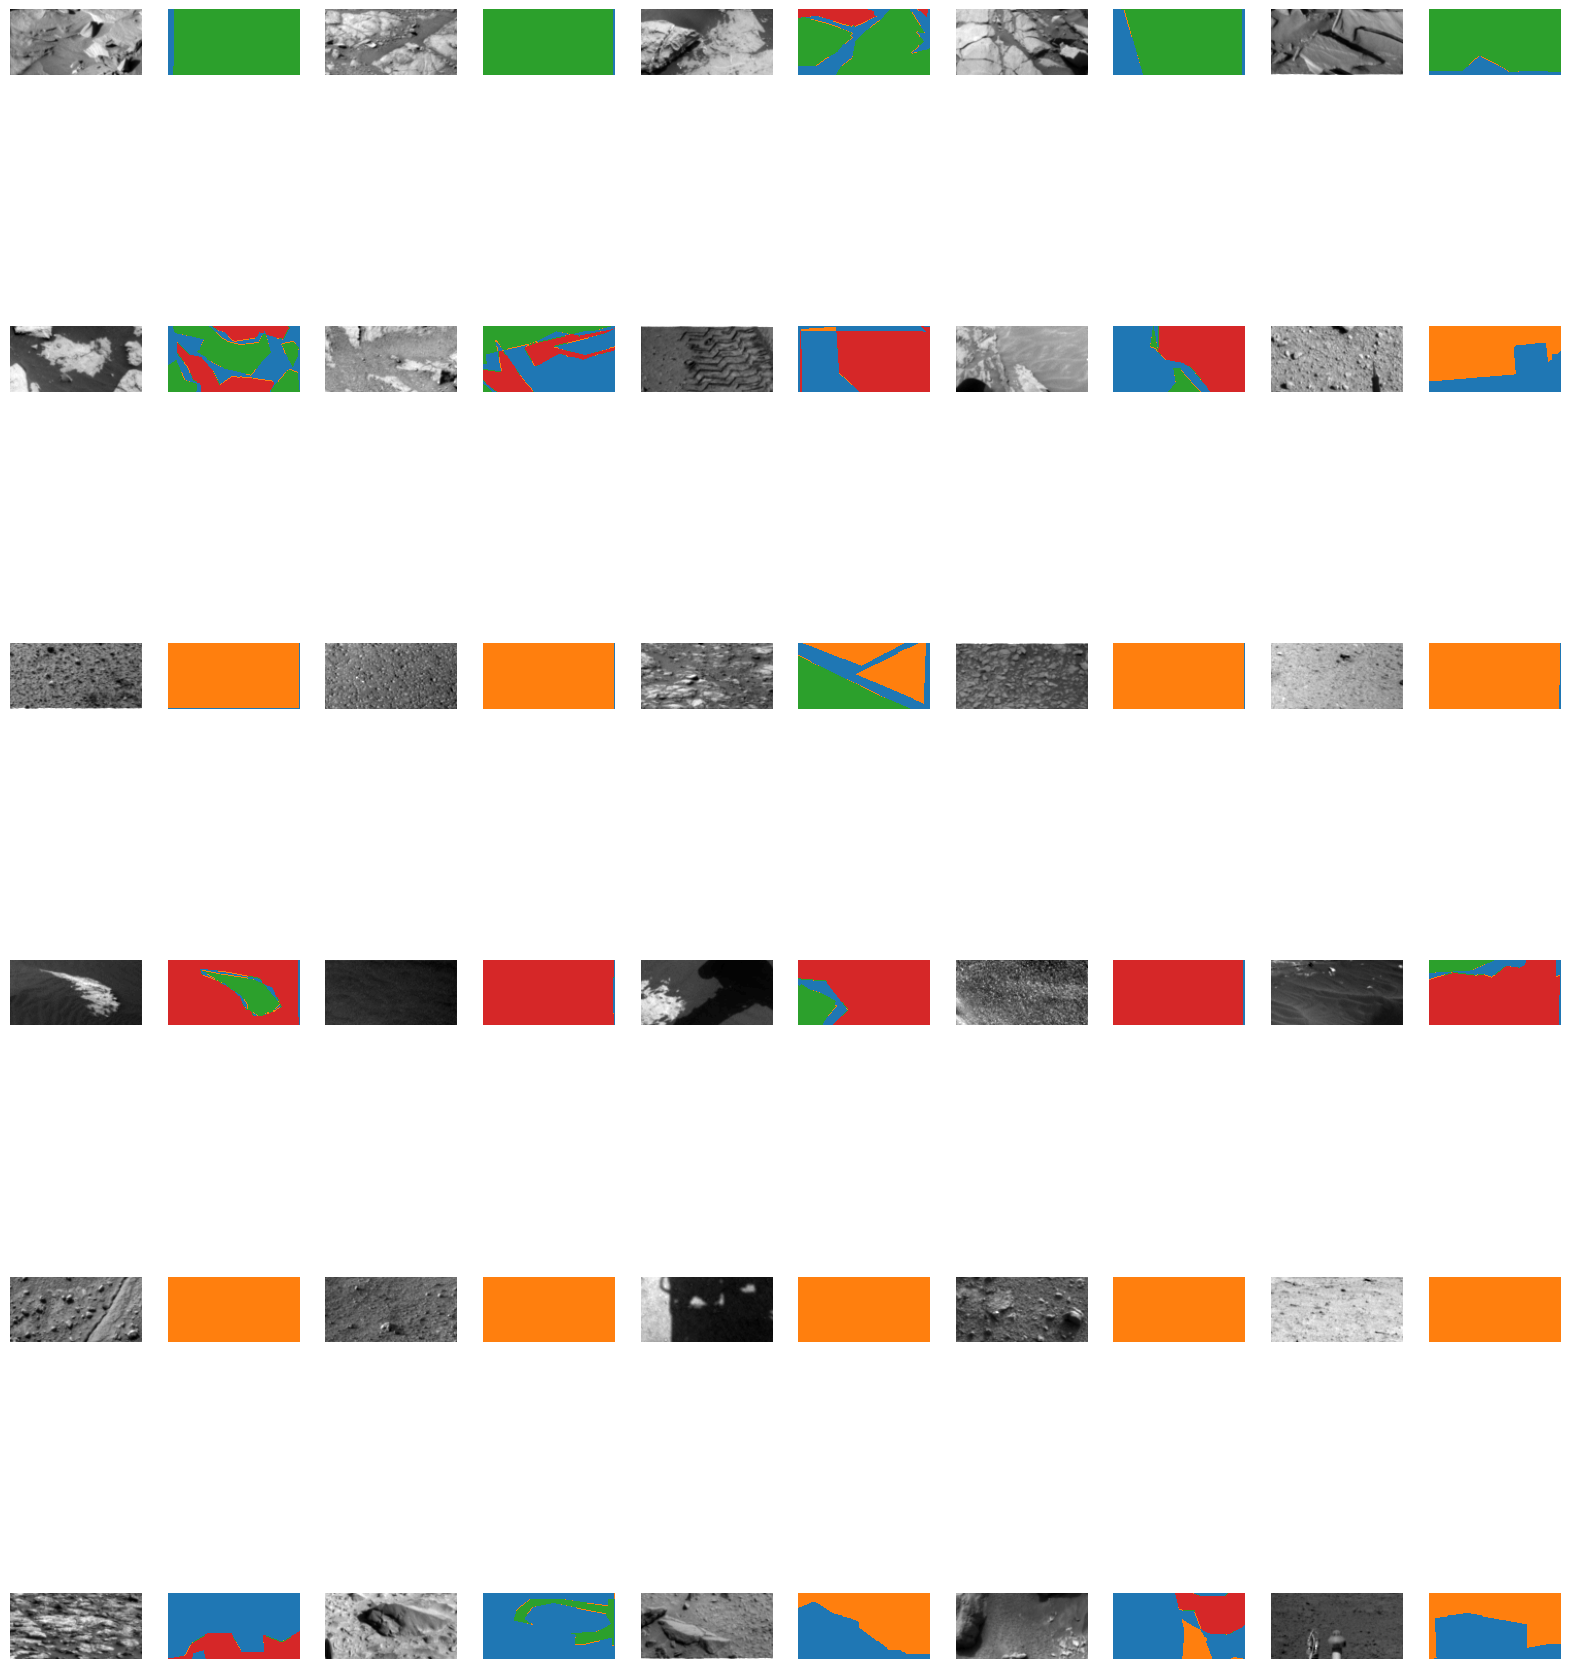

In [10]:
import random

from matplotlib.colors import ListedColormap
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Colors for each class
custom_cmap = ListedColormap(class_colors)


def plot_random_images_with_masks_from_clusters(X, masks, labels, num_clusters, num_images=5):
    plt.figure(figsize=(20, num_clusters * 4))
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        random_indices = random.sample(list(cluster_indices), num_images)
        for i, idx in enumerate(random_indices):
            plt.subplot(num_clusters, num_images * 2, cluster * num_images * 2 + i * 2 + 1)
            plt.imshow(X[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(f'Cluster {cluster}', size=12)
            plt.subplot(num_clusters, num_images * 2, cluster * num_images * 2 + i * 2 + 2)
            plt.imshow(masks[idx],  cmap=custom_cmap, vmin=0, vmax=len(class_colors) - 1)
            plt.axis('off')
    plt.show()

# Plot 5 random images with their masks from each cluster
plot_random_images_with_masks_from_clusters(X_train, y_train, kmeans_labels, num_clusters=6, num_images=5)

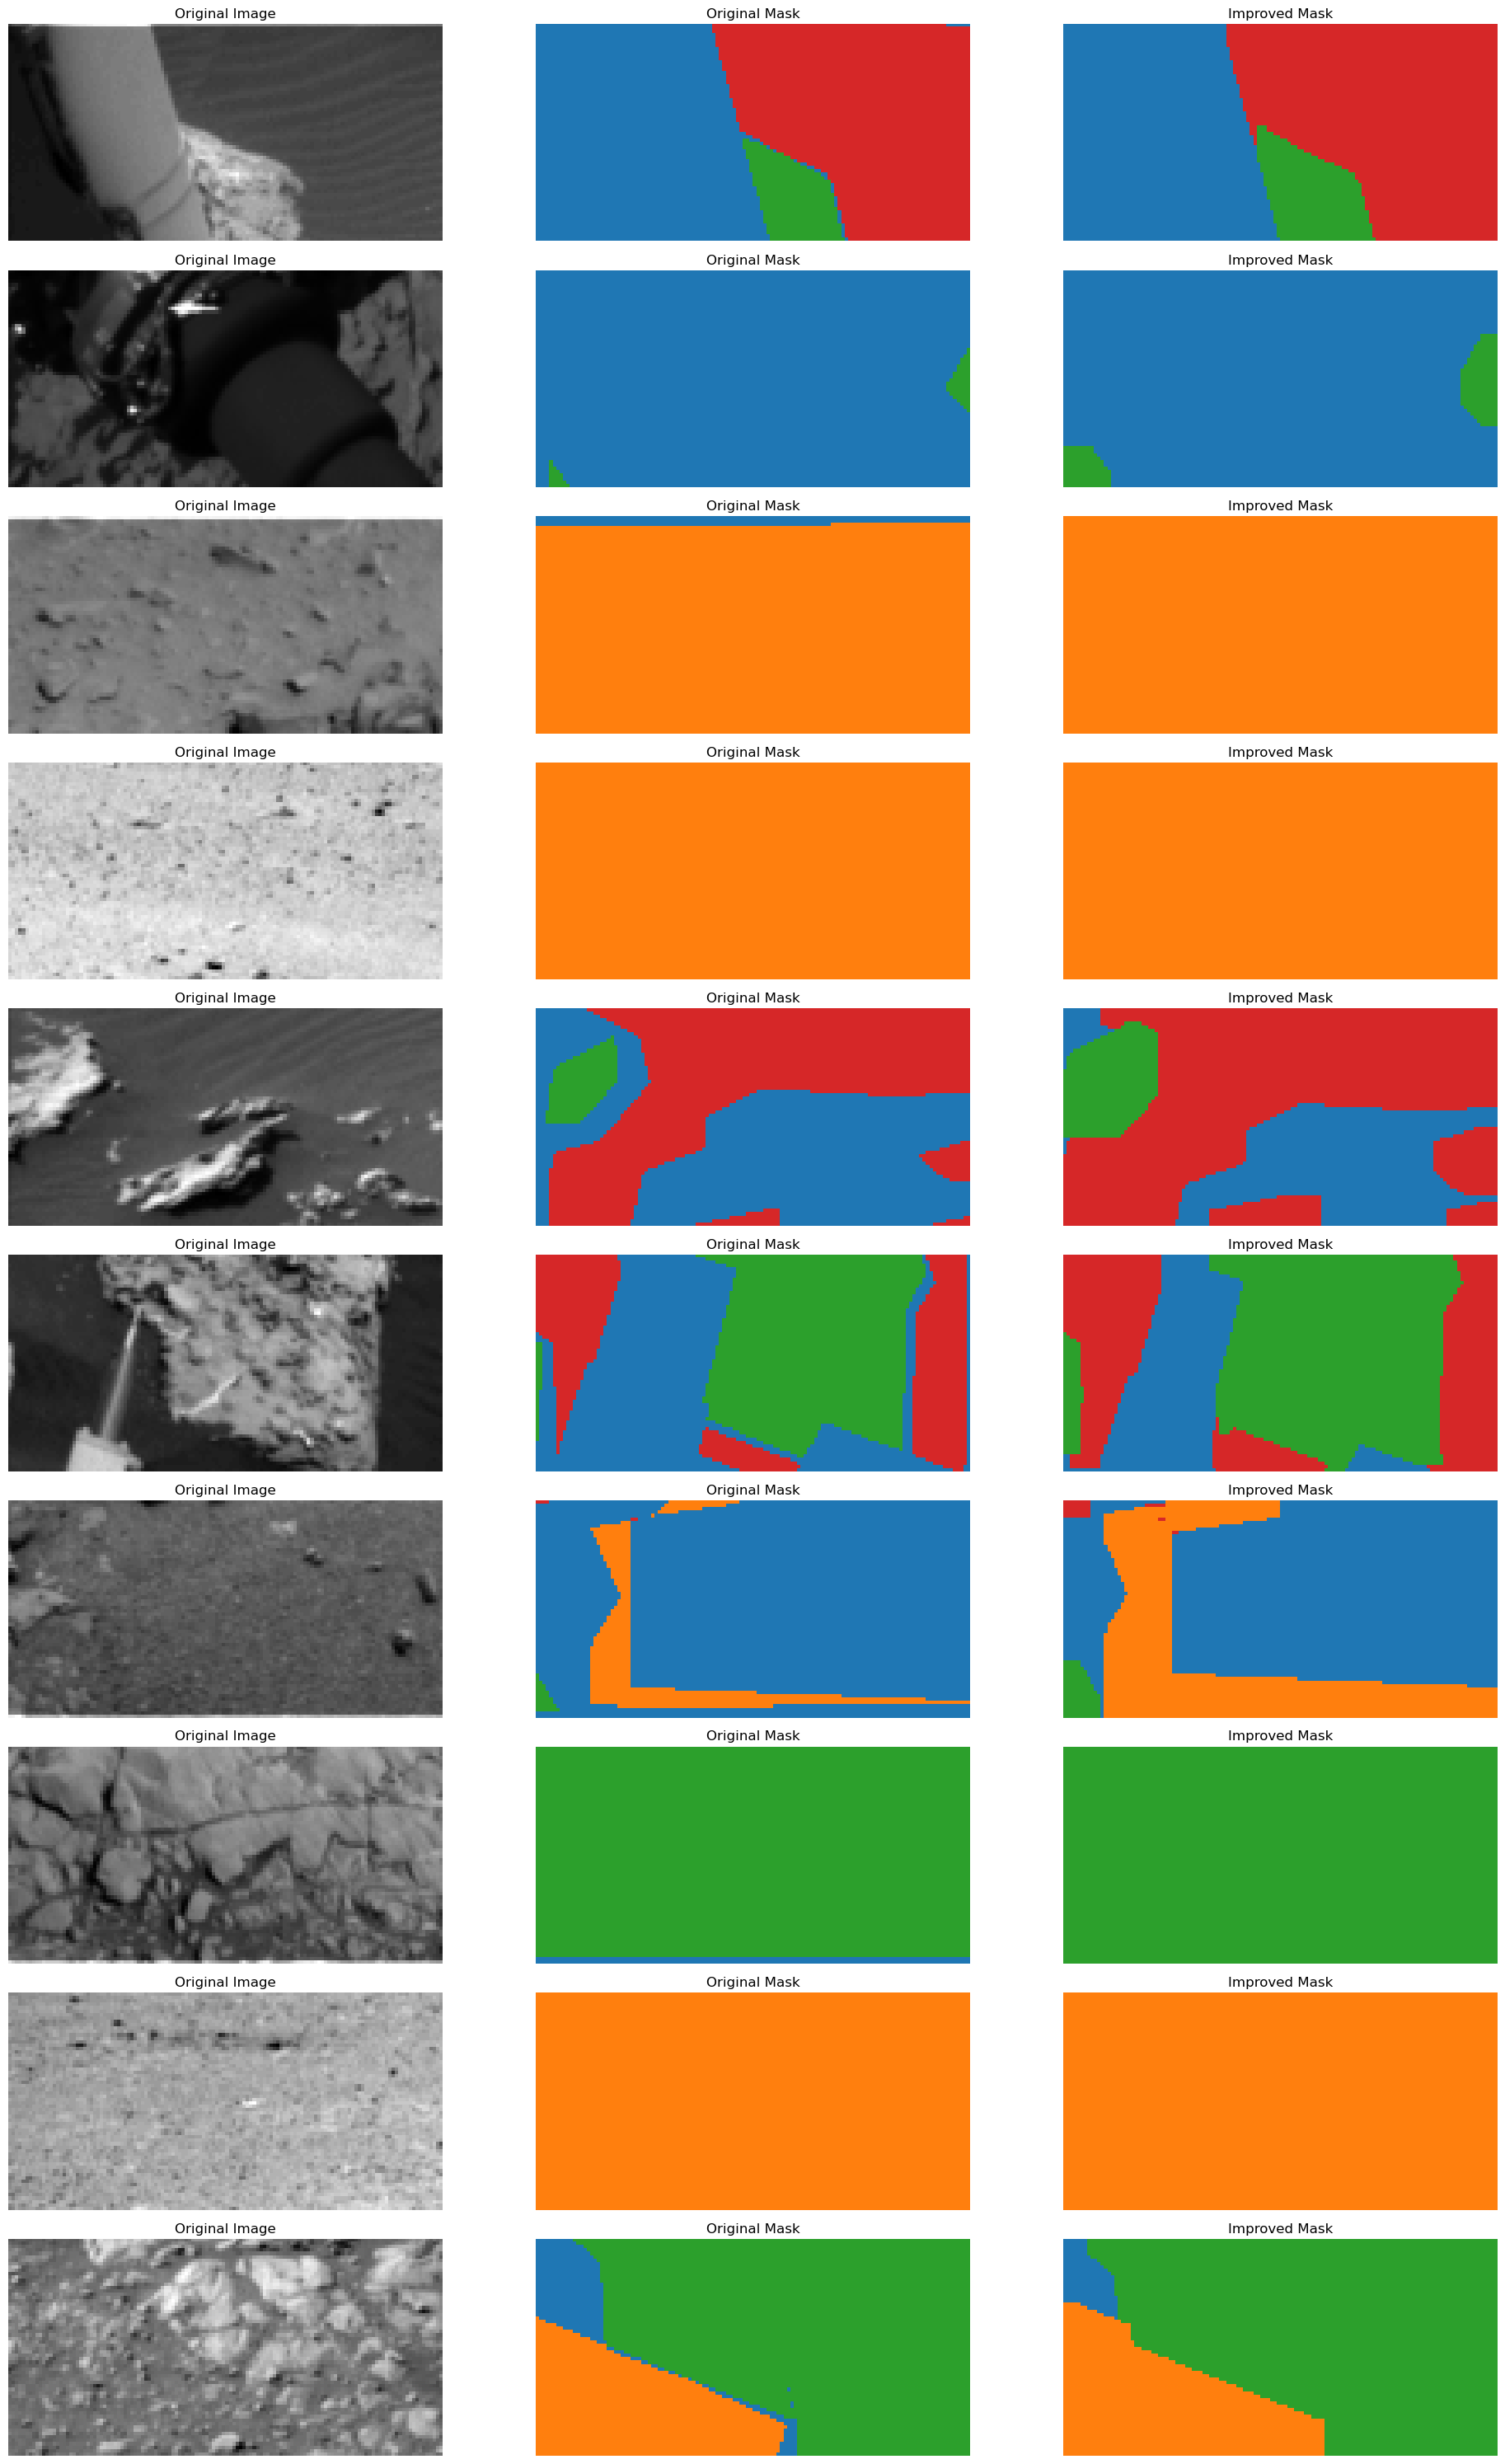

In [11]:
import cv2
import numpy as np

def fix_segmentation_mask(mask, num_classes):
    """
    Fixes segmentation mask by propagating the object class to the edges of each object.

    Args:
        mask (np.ndarray): 2D array (H, W) representing the segmentation mask with class labels.
        num_classes (int): The total number of classes in the segmentation task.

    Returns:
        np.ndarray: Fixed segmentation mask.
    """
    # Create a copy of the mask to modify
    fixed_mask = mask.copy()

    # Process each class individually
    for class_id in range(1, num_classes + 1):  # Assuming class 0 is the background
        # Extract binary mask for the current class
        class_mask = (mask == class_id).astype(np.uint8)

        # Detect edges using Canny edge detection
        edges = cv2.Canny(class_mask * 255, 100, 200)  # Scale to [0, 255] for Canny

        # Dilate the edges to ensure all boundary pixels are included
        kernel = np.ones((3, 3), np.uint8)
        dilated_edges = cv2.dilate(edges, kernel, iterations=1)

        # Expand the object to include edge pixels
        dilated_edges_binary = (dilated_edges > 0).astype(np.uint8)
        expanded_class = cv2.bitwise_or(class_mask, dilated_edges_binary)

        # Update the fixed mask with the propagated class labels
        fixed_mask[expanded_class > 0] = class_id

    #     # Plot the transformation steps
    #     plt.subplot(num_classes, 4, (class_id - 1) * 4 + 1)
    #     plt.imshow(class_mask, cmap='gray')
    #     plt.title(f'Class {class_id} Mask')
    #     plt.axis('off')

    #     plt.subplot(num_classes, 4, (class_id - 1) * 4 + 2)
    #     plt.imshow(edges, cmap='gray')
    #     plt.title(f'Class {class_id} Edges')
    #     plt.axis('off')

    #     plt.subplot(num_classes, 4, (class_id - 1) * 4 + 3)
    #     plt.imshow(dilated_edges, cmap='gray')
    #     plt.title(f'Class {class_id} Dilated Edges')
    #     plt.axis('off')

    #     plt.subplot(num_classes, 4, (class_id - 1) * 4 + 4)
    #     plt.imshow(expanded_class, cmap='gray')
    #     plt.title(f'Class {class_id} Expanded Class')
    #     plt.axis('off')

    # plt.tight_layout()
    # plt.show()

    return fixed_mask

def aggressive_fix_segmentation_mask(mask, num_classes, background_class=0, min_background_area=500):
    """
    Aggressively fixes segmentation masks by removing small background regions 
    and forcing class propagation to most of the mask.

    Args:
        mask (np.ndarray): 2D array (H, W) representing the segmentation mask with class labels.
        num_classes (int): The total number of classes in the segmentation task.
        background_class (int): The class ID representing the background.
        min_background_area (int): Minimum area for background regions to remain untouched.

    Returns:
        np.ndarray: Aggressively fixed segmentation mask.
    """
    # Create a copy of the mask
    fixed_mask = mask.copy()

    # Step 1: Identify large background regions
    background_mask = (mask == background_class).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(background_mask, connectivity=8)
    large_background = np.zeros_like(mask, dtype=np.uint8)

    for i in range(1, num_labels):  # Start at 1 to skip the background label
        if stats[i, cv2.CC_STAT_AREA] >= min_background_area:
            large_background[labels == i] = 1

    # Step 2: Expand classes aggressively
    for class_id in range(1, num_classes + 1):  # Skip the background class
        # Extract binary mask for the current class
        class_mask = (mask == class_id).astype(np.uint8)

        # Expand the class using morphological dilation
        kernel = np.ones((5, 5), np.uint8)  # Larger kernel for more aggressive expansion
        expanded_class = cv2.dilate(class_mask, kernel, iterations=3)

        # Apply the expanded class to the mask
        fixed_mask[expanded_class > 0] = class_id

    # Step 3: Remove small background regions
    small_background = (large_background == 0).astype(np.uint8)
    fixed_mask[small_background > 0] = fixed_mask[small_background > 0].max()  # Propagate the nearest class

    return fixed_mask

def balanced_fix_segmentation_mask(mask, num_classes, background_class=0, min_background_area=200):
    """
    Fixes segmentation masks by forcing classes to replace small background areas.

    Args:
        mask (np.ndarray): 2D array (H, W) representing the segmentation mask with class labels.
        num_classes (int): The total number of classes in the segmentation task.
        background_class (int): The class ID representing the background.
        min_background_area (int): Minimum area for background regions to remain untouched.

    Returns:
        np.ndarray: Refined segmentation mask with aggressive small background handling.
    """
    # Create a copy of the mask
    fixed_mask = mask.copy()

    # Step 1: Identify large background regions
    background_mask = (mask == background_class).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(background_mask, connectivity=8)
    large_background = np.zeros_like(mask, dtype=np.uint8)

    for i in range(1, num_labels):  # Skip the first component (background label itself)
        if stats[i, cv2.CC_STAT_AREA] >= min_background_area:
            large_background[labels == i] = 1

    # Step 2: Expand classes
    kernel = np.ones((5, 5), np.uint8)  # Intermediate kernel for balanced expansion
    for class_id in range(1, num_classes + 1):  # Exclude background
        class_mask = (mask == class_id).astype(np.uint8)
        expanded_class = cv2.dilate(class_mask, kernel, iterations=2)

        # Apply expanded classes only to background pixels
        fixed_mask[(expanded_class > 0) & (fixed_mask == background_class)] = class_id

    # Step 3: Handle small background regions by surrounding class absorption
    small_background = (large_background == 0).astype(np.uint8)
    small_background_indices = np.where((small_background > 0) & (fixed_mask == background_class))

    for y, x in zip(*small_background_indices):
        # Get all neighboring classes
        neighbors = fixed_mask[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
        neighbors = neighbors[neighbors != background_class]  # Exclude background
        neighbors = neighbors.astype(int)  # Cast neighbors to integers

        if len(neighbors) > 0:
            # Assign the most frequent neighboring class (no checks for dominance)
            fixed_mask[y, x] = np.bincount(neighbors).argmax()

    # Step 4: Preserve original valid objects to avoid overwriting
    valid_objects = (mask > 0).astype(np.uint8)
    fixed_mask[valid_objects > 0] = mask[valid_objects > 0]

    return fixed_mask

def oliver_try (mask, num_classes, background_class=0):
    # Ensure the mask is of type CV_8UC1
    mask = mask.astype(np.uint8)

    # Step 1: Morphological Operations
    kernel_size = max(1, mask.shape[0] // 50)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=1)

    # Step 2: Edge Smoothing
    mask = cv2.GaussianBlur(mask, (9, 9), sigmaX=2)

    # Step 3: Contour Correction
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon=0.01 * cv2.arcLength(cnt, True), closed=True) for cnt in contours]
    mask = np.zeros_like(mask)
    cv2.drawContours(mask, approx_contours, -1, (255), thickness=cv2.FILLED)

    # Step 4: Artifact Removal
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    min_area = 500
    filtered_mask = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            filtered_mask[labels == i] = 255
    mask = filtered_mask

    # Step 5: Regularization with Distance Transform
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, mask = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, cv2.THRESH_BINARY)
    
    return mask.astype(np.uint8)
    

sample_image = X_train[10]
sample_mask = y_train[10]
improved_mask = balanced_fix_segmentation_mask(sample_mask, num_classes=len(class_colors)-1)


num_samples = 10
random_indices = random.sample(range(len(X_train)), num_samples)

plt.figure(figsize=(20, num_samples * 3))

for i, idx in enumerate(random_indices):
    sample_image = X_train[idx]
    sample_mask = y_train[idx]
    improved_mask = balanced_fix_segmentation_mask(sample_mask, num_classes=len(class_colors)-1)
    
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(sample_mask, cmap=custom_cmap, vmin=0, vmax=len(class_colors) - 1)
    plt.title('Original Mask')
    plt.axis('off')
    
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(improved_mask, cmap=custom_cmap, vmin=0, vmax=len(class_colors) - 1)
    plt.title('Improved Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
from tqdm import tqdm
import os

import numpy as np

dataset_cleaned = np.load('../data/mars_trainning_set_clean_no_aliens.npz', allow_pickle=True)
X_train = dataset_cleaned['images']
y_train = dataset_cleaned['masks']

# Create a directory to save the fixed masks if it doesn't exist
output_dir = '../data/'
os.makedirs(output_dir, exist_ok=True)

# Apply balanced_fix_segmentation_mask to the entire dataset
fixed_masks = np.zeros_like(y_train)

for i in tqdm(range(len(y_train)), desc="Applying balanced_fix_segmentation_mask"):
    fixed_masks[i] = balanced_fix_segmentation_mask(y_train[i], num_classes=len(class_colors)-1)

# Save the fixed masks
np.savez_compressed(os.path.join(output_dir, 'mars_training_set_fixed_masks.npz'),images=X_train, masks=fixed_masks)

FileNotFoundError: [Errno 2] No such file or directory: '../data/mars_trainning_set_clean_no_aliens.npz'